In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

O método numérico de Boris é utilizado para integrar a equação de movimento de uma partícula carregada na presença de campos elétricos e magnéticos preescritos. Para mais informações consultar o capítulo 4 do livro **Plasma physics via computer simulation** do Birdsall e Langdon.

In [2]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
def push_particles(q,m,dt,c,efield,bfield,u,r,v):
    
    import numpy as np
    
    #me = 9.109e-31; qe = 1.602e-19; Re = 6.371e6
    
    me = 1.0
    qe = 1.0
    
    ex = efield[0]; ey = efield[1]; ez = efield[2]
    bx = bfield[0]; by = bfield[1]; bz = bfield[2]
    vx = v[0]; vy = v[1]; vz = v[2] 
    ux = u[0]; uy = u[1]; uz = u[2]
    rx = r[0]; ry = r[1]; rz = r[2] 

    # Fator de Lorentz
    gamma = 1.0/np.sqrt(1-(vx**2+vy**2+vz**2)/c**2)

    # uminus
    umx = ux + ((q*qe)*dt/(2*(m*me)))*ex
    umy = uy + ((q*qe)*dt/(2*(m*me)))*ey
    umz = uz + ((q*qe)*dt/(2*(m*me)))*ez

    # uprime = uminus + (qdt/2mgamma)*(uminus x B) 
    uprx = umx +((q*qe)*dt/(2*(m*me)*gamma))*(umy*bz - umz*by)
    upry = umy +((q*qe)*dt/(2*(m*me)*gamma))*(umz*bx - umx*bz)
    uprz = umz +((q*qe)*dt/(2*(m*me)*gamma))*(umx*by - umy*bx)

    # S = (qdt/(mgamma))B/(1+(qdtB/2mgamma)^2)
    bm = np.sqrt(bx**2+by**2+bz**2)
    sx = (((q*qe)*dt/((m*me)*gamma))*bx)/(1 + ((q*qe)*dt*bm/(2*(m*me)*gamma))**2)
    sy = (((q*qe)*dt/((m*me)*gamma))*by)/(1 + ((q*qe)*dt*bm/(2*(m*me)*gamma))**2)
    sz = (((q*qe)*dt/((m*me)*gamma))*bz)/(1 + ((q*qe)*dt*bm/(2*(m*me)*gamma))**2)

    # uplus = uminus + (uprime x S)
    upx = umx + (upry*sz - uprz*sy)
    upy = umy + (uprz*sx - uprx*sz)
    upz = umz + (uprx*sy - upry*sx)	

    # u^(n+1/2) = uplus + (qdt/2m)*E (Campo elétrico)
    ux = upx + ((q*qe)*dt/(2*(m*me)))*ex
    uy = upy + ((q*qe)*dt/(2*(m*me)))*ey
    uz = upz + ((q*qe)*dt/(2*(m*me)))*ez
    um = np.sqrt(ux*ux + uy*uy + uz*uz)
    gamma = np.sqrt(1+(um*um)/(c*c))

    # Atualização da velocidade da partícula 
    u[0] = ux; u[1] = uy; u[2] = uz
    vx = ux/gamma; vy = uy/gamma; vz = uz/gamma
    v[0] = vx; v[1] = vy; v[2] = vz

    #Atualização da posição da partículas
    r[0] = rx + (dt*vx)
    r[1] = ry + (dt*vy)
    r[2] = rz + (dt*vz)
    
    return r,v  #Retorna os vetores posição e velocidade 

## Configuração dos parâmetros de simulação 

In [4]:
dt = 1e-2        # Passo temporal
Nsteps = 10000   # Número de passos numéricos
npart = 1        # Número de partículas
skip = 1         # Passo utilizado para salvamento dos dados
#c = 299792458    # Velocidade da luz (299 792 458 m/s)
c = 30 

t=np.zeros([int(Nsteps/skip)+1, npart])

In [8]:
# Carga e massa das partículas estão dadas em função da carga elementar e da massa do elétron (próton +1 e elétron -1, sendo a massa do próton 1.836e3)

q = -1
m = 1

# Posição inicial 
x0 = 0.0; y0 = 0.0 ; z0 = 0.0

# Velocidade inicial 
vx0 = 1; vy0 = 0; vz0 = 0

# Campos elétrico e magnético iniciais 
Bx0 = 0; By0 = 0;   Bz0 = 1

Ex0 = 0; Ey0 = 0.1; Ez0 = 0

## Simulação

In [9]:
#Definição dos vetores posição e velocidade

v0 = np.array([vx0,vy0,vz0])
r0 = np.array([x0, y0, z0])

rx = np.zeros([int(Nsteps/skip)+1,npart]); ry = np.zeros([int(Nsteps/skip)+1,npart]); rz = np.zeros([int(Nsteps/skip)+1,npart])
vx = np.zeros([int(Nsteps/skip)+1,npart]); vy = np.zeros([int(Nsteps/skip)+1,npart]); vz = np.zeros([int(Nsteps/skip)+1,npart])
ek = np.zeros([int(Nsteps/skip)+1,npart]); mu = np.zeros([int(Nsteps/skip)+1,npart]); rL = np.zeros([int(Nsteps/skip)+1,npart])

bfield = np.array([Bx0,By0,Bz0])
efield = np.array([Ex0,Ey0,Ez0])

# Loop

for i in range(npart):  # Loop para n partículas
    
    counter=0
    
    #L Fator de Lorentz
    gammaL = 1.0/np.sqrt(1.0-(v0[0]**2+v0[1]**2+v0[2]**2)/c**2)
    
    # Velocidade relativística
    u = np.array([gammaL*v0[0], gammaL*v0[1], gammaL*v0[2]])
    
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v0[0];  vy[0,i]=v0[1];  vz[0,i]=v0[2]
    ek[0,i]=gammaL-1 
    
    if np.linalg.norm(bfield) == 0:
        mu[0,i]=0
        rL[0,i]=0
    else:
        mu[0,i]=(gammaL-1)/(np.linalg.norm(bfield))
        rL[0,i]=m*np.sqrt(v0[0]**2+v0[1]**2+v0[2]**2)/(np.abs(q)*np.linalg.norm(bfield))
    
    r = np.array([rx[0,i],ry[0,i],rz[0,i]])
    v = np.array([vx[0,i],vy[0,i],vz[0,i]])
  
    
    for it in range(Nsteps):   # Loop temporal para cada partícula
                                          
        r,v = push_particles(q,m,dt,c,efield,bfield,u,r,v)  # Utilização do algoritmo de Boris
        
        if np.mod(it,skip) == 0:  # Condição para salvamento dos vetores
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            ek[counter+1,i]= 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)-1
            
            if np.linalg.norm(bfield) == 0:
                mu[counter+1,i] = 0
                vperp = 0
                rL[counter+1,i] = 0
            else:
                
                mu[counter+1,i]=(1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)-1)/np.linalg.norm(bfield)      # Energia cinética
                vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield)))              # Velocidade perpendicular
                rL[counter+1,i]=m*vperp/(np.abs(q)*np.linalg.norm(bfield))                                      # Raio de Larmor
            
            t[counter+1,i]=t[counter,i]+dt*skip
            counter+=1

## Gráficos 

### Pósitron (antipartícula do elétron)

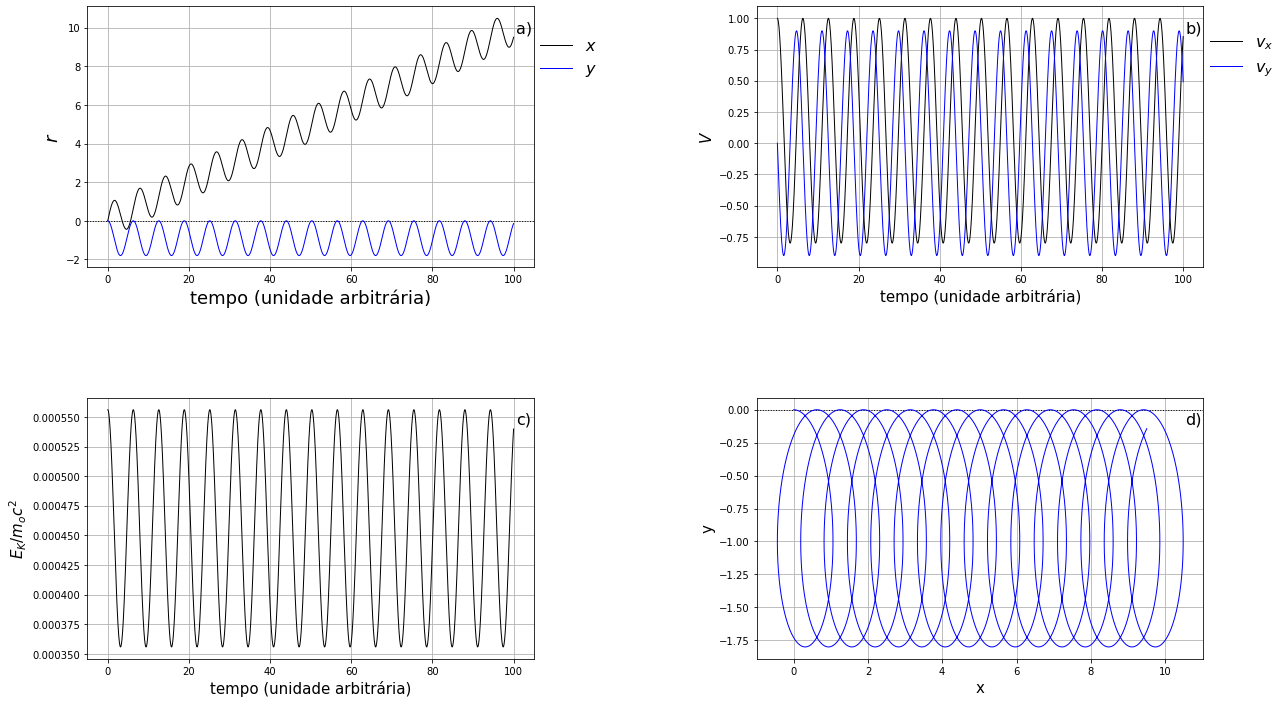

In [7]:
fig,ax = plt.subplots(2,2,gridspec_kw={'hspace': 0.5,'wspace':0.5},figsize=(20,12))

ax[0,0].plot(t,rx,ls ='-' , lw=1,color='k', label=r'$x$'  ,zorder=2)
ax[0,0].plot(t,ry,ls ='-' , lw=1,color='b', label=r'$y$',zorder=3)

ax[0,0].axhline(0, color='black',lw = 1,linestyle=":",zorder=2)
ax[0,0].grid(axis='both')
ax[0,0].annotate('a)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[0,0].set_xlabel('tempo (unidade arbitrária)', fontsize = 18)
ax[0,0].set_ylabel(r'$r$',fontsize=18)
ax[0,0].legend(loc=(1.00,0.7), frameon=False, fontsize=16)


ax[0,1].plot(t,vx,lw=1,color='k',label=r'$v_x$')
ax[0,1].plot(t,vy,lw=1,color='b',label=r'$v_y$')
ax[0,1].set_xlabel('tempo (unidade arbitrária)', fontsize = 15);ax[0,1].set_ylabel(r'$V$', fontsize= 15)
ax[0,1].grid(axis='both')
ax[0,1].annotate('b)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[0,1].legend(loc=(1.00,0.7), frameon=False, fontsize=16)


ax[1,0].plot(t,ek,lw=1, color='k')
ax[1,0].set_xlabel('tempo (unidade arbitrária)',fontsize = 15)
ax[1,0].set_ylabel(r'$E_K/m_oc^2$',fontsize = 15)
ax[1,0].annotate('c)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[1,0].grid(axis='both')

ax[1,1].plot(rx,ry,lw=1,color='b', label=r'$p$',zorder=3)
ax[1,1].axhline(0, color='black',lw = 1,linestyle=":",zorder=2)
ax[1,1].set_xlabel('x',fontsize = 15);ax[1,1].set_ylabel('y',fontsize = 15)
ax[1,1].annotate('d)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[1,1].grid(axis='both')
#ax[1,1].set_aspect(1)
#ax[1,1].legend(loc=(1.00,0.8), frameon=False)


plt.show()

### Elétron

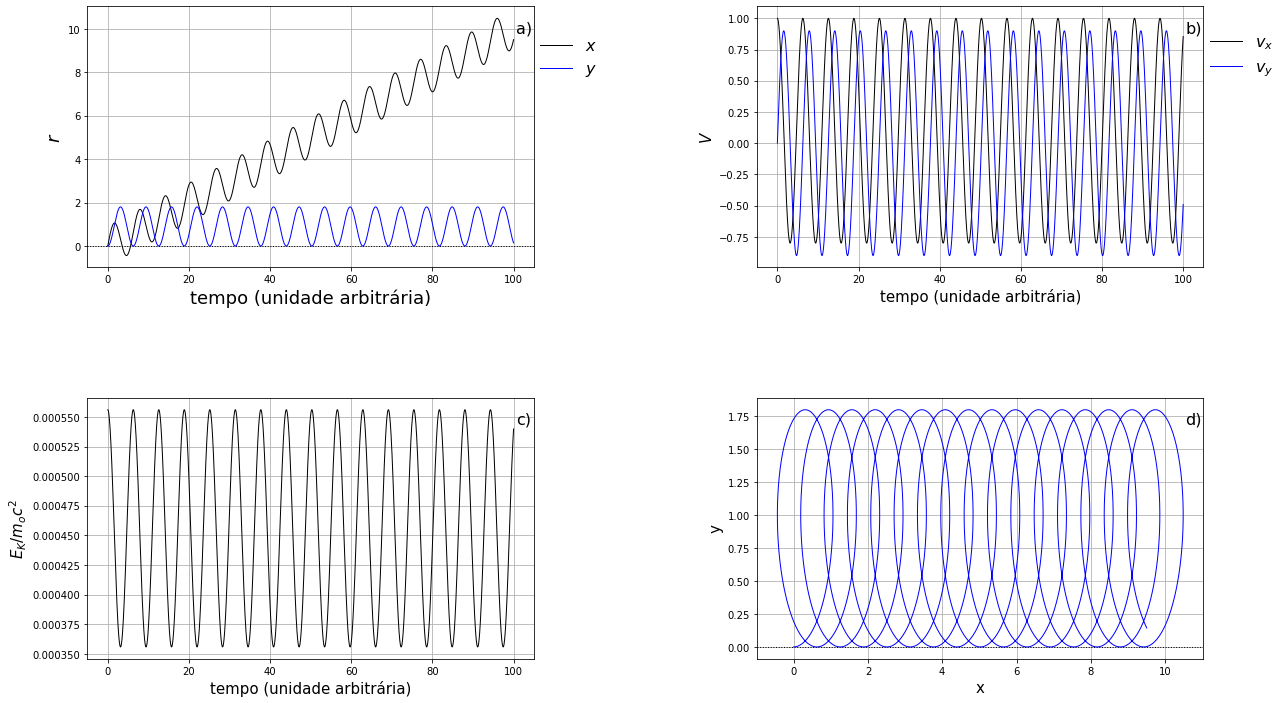

In [10]:
fig,ax = plt.subplots(2,2,gridspec_kw={'hspace': 0.5,'wspace':0.5},figsize=(20,12))

ax[0,0].plot(t,rx,ls ='-' , lw=1,color='k', label=r'$x$'  ,zorder=2)
ax[0,0].plot(t,ry,ls ='-' , lw=1,color='b', label=r'$y$',zorder=3)

ax[0,0].axhline(0, color='black',lw = 1,linestyle=":",zorder=2)
ax[0,0].grid(axis='both')
ax[0,0].annotate('a)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[0,0].set_xlabel('tempo (unidade arbitrária)', fontsize = 18)
ax[0,0].set_ylabel(r'$r$',fontsize=18)
ax[0,0].legend(loc=(1.00,0.7), frameon=False, fontsize=16)


ax[0,1].plot(t,vx,lw=1,color='k',label=r'$v_x$')
ax[0,1].plot(t,vy,lw=1,color='b',label=r'$v_y$')
ax[0,1].set_xlabel('tempo (unidade arbitrária)', fontsize = 15);ax[0,1].set_ylabel(r'$V$', fontsize= 15)
ax[0,1].grid(axis='both')
ax[0,1].annotate('b)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[0,1].legend(loc=(1.00,0.7), frameon=False, fontsize=16)


ax[1,0].plot(t,ek,lw=1, color='k')
ax[1,0].set_xlabel('tempo (unidade arbitrária)',fontsize = 15)
ax[1,0].set_ylabel(r'$E_K/m_oc^2$',fontsize = 15)
ax[1,0].annotate('c)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[1,0].grid(axis='both')

ax[1,1].plot(rx,ry,lw=1,color='b', label=r'$p$',zorder=3)
ax[1,1].axhline(0, color='black',lw = 1,linestyle=":",zorder=2)
ax[1,1].set_xlabel('x',fontsize = 15);ax[1,1].set_ylabel('y',fontsize = 15)
ax[1,1].annotate('d)', xy=(0.96,0.90), xycoords='axes fraction',size=16)
ax[1,1].grid(axis='both')
#ax[1,1].set_aspect(1)
#ax[1,1].legend(loc=(1.00,0.8), frameon=False)


plt.show()

### Referências  

* BIRDSALL, Charles K.; LANGDON, A. Bruce. Plasma physics via computer simulation. CRC press, 2018.